This notebook is dedicated to implementing and evaluating K-Shape clustering on multivariate time series data for Human Activity Recognition. K-Shape is a shape-based clustering algorithm that uses the Shape-Based Distance (SBD) metric, which is invariant to scaling and shifting along the time axis.Since K-Shape is inherently a univariate algorithm, a crucial step is the dimensionality reduction of the 9-channel multivariate input data to a single channel. This notebook explores the impact of different reduction methods on the final clustering quality:
- Reduction by Mean: Averaging all 9 channels at each time step.
- Reduction by Variable Selection: Selecting a single, representative channel.The notebook proceeds as follows:
1. Data Loading and Preprocessing: Loads the raw time series data and applies Z-normalization per series (which K-Shape assumes implicitly for SBD to work correctly).
2. Clustering Execution: Runs the run_kshape function, which performs the dimensionality reduction before clustering.
3. Evaluation: Computes external metrics (ARI, NMI, Purity) and an internal metric based on the SBD distance matrix (SBD Silhouette Score).
4. Visualization: Uses t-SNE on the SBD distance matrix to visualize the data in 2D, and plots the confusion matrix (aligned using the Hungarian algorithm).
5. Grid Search: Explores the influence of hyperparameters.

1. Import Libraries

In [ ]:
import sys; sys.path.append("..")
import numpy as np
from src.cluster_kshape import run_kshape
from src.eval import external_scores, confusion_with_hungarian, silhouette_by_metric
from src.distances import sbd_distance_matrix
from src.viz import embed_tsne_from_dist, scatter_2d, plot_confusion_matrix
from src.utils_io import save_clustering_results
from src.io import load_dataset
from src.preprocess import z_norm_per_series
import time
from itertools import product

2. Load Data and Apply Z-Normalization

In [2]:
# Load dataset
X_train, X_test, y_train, y_test = load_dataset("../data/raw", test_size=0.2, random_state=42)

# Preprocessing: z-normalization (per series)
Xn_train = z_norm_per_series(X_train)
Xn_test  = z_norm_per_series(X_test)

3. Execute K-Shape Clustering

In [ ]:
# Clustering
y_pred, model, centers, X_uni = run_kshape(
    Xn_train,                 # (n, d, T) z-normalized by window
    n_clusters=6,
    n_init=10,
    max_iter=50,
    random_state=42,
    reduce_mode="mean",       # "pca1" | "var" | "mean"
    var_idx=None,
    verbose=False
)

4. Evaluation

External metrics (train): {'ARI': 0.6150494535966322, 'NMI': np.float64(0.5826331654569947), 'Purity': np.float64(0.7184115523465704)}


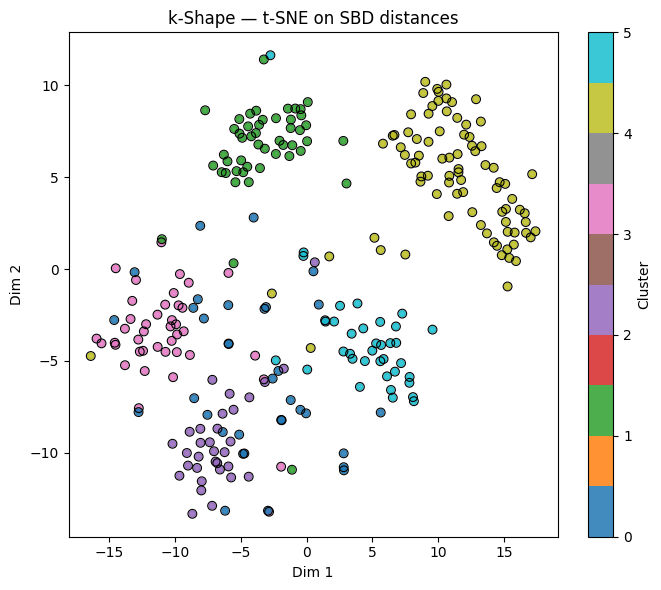

Silhouette SBD (train): 0.224


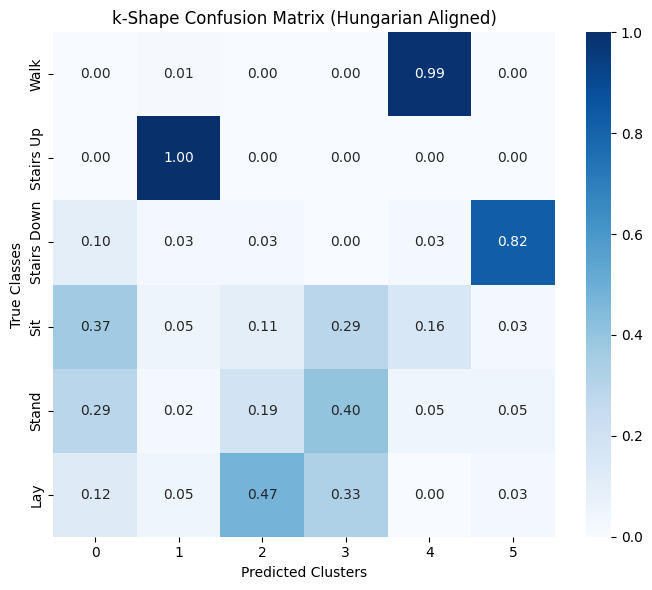

In [ ]:
#external metrics 
scores = external_scores(y_train, y_pred)
print("External metrics (train):", scores)


#Mapping & confusion
y_pred_mapped, C, mapping = confusion_with_hungarian(y_train, y_pred)
mapping_clean = {int(k): int(v) for k, v in mapping.items()}

#Visualisation (SBD)
D = sbd_distance_matrix(X_uni)                 # (n,n)
X2 = embed_tsne_from_dist(D, perplexity=30, random_state=42)
fig = scatter_2d(X2, y_pred, "k-Shape — t-SNE on SBD distances", y_true=y_train, show=True)

#internal metric
silhouette_sbd = silhouette_by_metric(D, y_pred, metric="precomputed")
print(f"Silhouette SBD (train): {silhouette_sbd:.3f}")

#confusion matrix
true_labels = np.sort(np.unique(y_train))
pred_labels = np.sort(np.unique(y_pred))
fig = plot_confusion_matrix(
    C, true_labels, pred_labels,
    label_to_activity={1:"Walk",2:"Stairs Up",3:"Stairs Down",4:"Sit",5:"Stand",6:"Lay"},
    normalize=True,
    title="k-Shape Confusion Matrix (Hungarian Aligned)",
    show=True
)


5. Grid Search 

In [ ]:
RESULTS_DIR = "../results"
METHOD_NAME = "kshape_3"

#hyperparameter grid
N_CLUSTERS_LIST   = [6]         
N_INIT_LIST       = [10, 15, 20, 25]    
MAX_ITER_LIST     = [50, 80, 100]

REDUCE_MODE_LIST  = ["mean", "var"]
VAR_IDX_LIST      = [0, 3, 6]   # only used if reduce_mode="var"
RANDOM_SEEDS = [42]

# Options
COMPUTE_EMBEDDING = True
SAVE_FIGURES      = True
SUBSAMPLE_RATIO   = 1.0


#Preprocessing already done:
# Xn_train = z_norm_per_series(X_train)
X_clean = Xn_train.copy()
ytrue   = y_train.copy()

# Option: subsample for faster testing
if SUBSAMPLE_RATIO < 1.0:
    rng = np.random.default_rng(0)
    idx = rng.choice(len(ytrue), size=int(len(ytrue)*SUBSAMPLE_RATIO), replace=False)
    X_clean = X_clean[idx]
    ytrue   = ytrue[idx]


#Helper: run one configuration
def run_one(n_clusters, n_init, max_iter, reduce_mode, var_idx, seed):

    print(f"\nRunning k-Shape: mode={reduce_mode}, var_idx={var_idx}, "
          f"k={n_clusters}, n_init={n_init}, max_iter={max_iter}, seed={seed}")

    t0 = time.time()

    # 1) Clustering
    y_pred, model, centers, X_uni = run_kshape(
        X_clean,
        n_clusters=n_clusters,
        n_init=n_init,
        max_iter=max_iter,
        random_state=seed,
        reduce_mode=reduce_mode,
        var_idx=var_idx,
        verbose=False
    )

    # 2) Scoring
    scores = external_scores(ytrue, y_pred)

    # 3) Hungarian mapping
    y_pred_mapped, C, mapping = confusion_with_hungarian(ytrue, y_pred)
    mapping_clean = {int(k): int(v) for k, v in mapping.items()}

    # 4) SBD distance matrix + t-SNE
    D = X2 = None
    if COMPUTE_EMBEDDING:
        D = sbd_distance_matrix(X_uni)
        X2 = embed_tsne_from_dist(D, perplexity=30, random_state=seed)

    # 5) Save parameters
    params = {
        "n_clusters": n_clusters,
        "n_init": n_init,
        "max_iter": max_iter,
        "reduce_mode": reduce_mode,
        "var_idx": var_idx,
        "metric": "sbd",
        "random_state": seed,
    }

    # 6) Save everything
    root, arr_dir, fig_dir, run_id = save_clustering_results(
        method_name=METHOD_NAME,
        y_pred=y_pred,
        y_true=ytrue,
        scores=scores,
        centers=centers,               # (k, T, 1)
        mapping=mapping_clean,
        embedding_2d=X2,
        dist_matrix=D,
        confusion=C,
        labels_true=np.sort(np.unique(ytrue)),
        labels_pred=np.sort(np.unique(y_pred)),
        params=params,
        output_dir=RESULTS_DIR,
        run_id=None
    )

    # 7) Save figures
    if SAVE_FIGURES and X2 is not None:
        import matplotlib.pyplot as plt

        fig = scatter_2d(X2, y_pred,
                         title=f"k-Shape — t-SNE ({reduce_mode}, var={var_idx})",
                         y_true=ytrue, show=False)
        fig.savefig(f"{fig_dir}/tsne.png", dpi=150)
        plt.close(fig)

        fig = plot_confusion_matrix(
            C,
            labels_true=np.sort(np.unique(ytrue)),
            labels_pred=np.sort(np.unique(y_pred)),
            label_to_activity={1:"Walk",2:"Stairs Up",3:"Stairs Down",4:"Sit",5:"Stand",6:"Lay"},
            normalize=True,
            title="k-Shape Confusion Matrix (Hungarian Aligned)",
            show=False
        )
        fig.savefig(f"{fig_dir}/confusion.png", dpi=150)
        plt.close(fig)

    elapsed = time.time() - t0
    return {
        "run_dir": root,
        "run_id": run_id,
        "params": params,
        "scores": scores,
        "time_sec": elapsed
    }


#Main Grid Loop
results = []

for n_clusters, n_init, max_iter, reduce_mode, seed in product(
    N_CLUSTERS_LIST,
    N_INIT_LIST,
    MAX_ITER_LIST,
    REDUCE_MODE_LIST,
    RANDOM_SEEDS
):
    # For mode="var": must loop over VAR_IDX_LIST
    if reduce_mode == "var":
        for var_idx in VAR_IDX_LIST:
            out = run_one(n_clusters, n_init, max_iter, reduce_mode, var_idx, seed)
            results.append(out)
    else:
        out = run_one(n_clusters, n_init, max_iter, reduce_mode, None, seed)
        results.append(out)


#Tabular summary
import pandas as pd

rows = []
for r in results:
    row = {**r["params"], **r["scores"], "time_sec": r["time_sec"], "run_dir": r["run_dir"]}
    rows.append(row)

df = pd.DataFrame(rows).sort_values(["ARI","NMI"], ascending=False)
display(df)


Running k-Shape: mode=mean, var_idx=None, k=6, n_init=10, max_iter=50, seed=42
✅ Saved run to: ../results\kshape_3\2025-11-13_16-08-39_seed42

Running k-Shape: mode=var, var_idx=0, k=6, n_init=10, max_iter=50, seed=42
✅ Saved run to: ../results\kshape_3\2025-11-13_16-09-31_seed42

Running k-Shape: mode=var, var_idx=3, k=6, n_init=10, max_iter=50, seed=42
✅ Saved run to: ../results\kshape_3\2025-11-13_16-10-32_seed42

Running k-Shape: mode=var, var_idx=6, k=6, n_init=10, max_iter=50, seed=42
✅ Saved run to: ../results\kshape_3\2025-11-13_16-11-13_seed42

Running k-Shape: mode=mean, var_idx=None, k=6, n_init=10, max_iter=80, seed=42
✅ Saved run to: ../results\kshape_3\2025-11-13_16-12-16_seed42

Running k-Shape: mode=var, var_idx=0, k=6, n_init=10, max_iter=80, seed=42
✅ Saved run to: ../results\kshape_3\2025-11-13_16-13-14_seed42

Running k-Shape: mode=var, var_idx=3, k=6, n_init=10, max_iter=80, seed=42
✅ Saved run to: ../results\kshape_3\2025-11-13_16-14-14_seed42

Running k-Shape: m

,n_clusters,n_init,max_iter,reduce_mode,var_idx,metric,random_state,ARI,NMI,Purity,time_sec,run_dir
0,6,10,50,mean,NaN,sbd,42,0.615049,0.582633,0.718412,28.441467,../results\kshape_3\2025-11-13_16-08-39_seed42
4,6,10,80,mean,NaN,sbd,42,0.615049,0.582633,0.718412,63.516443,../results\kshape_3\2025-11-13_16-12-16_seed42
8,6,10,100,mean,NaN,sbd,42,0.615049,0.582633,0.718412,64.814599,../results\kshape_3\2025-11-13_16-16-35_seed42
12,6,15,50,mean,NaN,sbd,42,0.615049,0.582633,0.718412,91.625353,../results\kshape_3\2025-11-13_16-21-19_seed42
16,6,15,80,mean,NaN,sbd,42,0.615049,0.582633,0.718412,92.859273,../results\kshape_3\2025-11-13_16-27-24_seed42
20,6,15,100,mean,NaN,sbd,42,0.615049,0.582633,0.718412,91.009124,../results\kshape_3\2025-11-13_16-31-52_seed42
24,6,20,50,mean,NaN,sbd,42,0.615049,0.582633,0.718412,112.386470,../results\kshape_3\2025-11-13_16-38-14_seed42
28,6,20,80,mean,NaN,sbd,42,0.615049,0.582633,0.718412,112.211814,../results\kshape_3\2025-11-13_16-45-54_seed42
32,6,20,100,mean,NaN,sbd,42,0.615049,0.582633,0.718412,8609.925414,../results\kshape_3\2025-11-13_19-14-46_seed42
36,6,25,50,mean,NaN,sbd,42,0.615049,0.582633,0.718412,61.265288,../results\kshape_3\2025-11-13_19-18-30_seed42
